In [1]:
import pandas as pd
from graphdatascience import GraphDataScience
from getpass import getpass
import kmedoids
import numpy as np
from matplotlib import pyplot as plt

Connecting Jupyter Notebook to Neo4j 

In [2]:
neo4j_pwd = getpass("Neo4j password")

Neo4j password ········


In [3]:
connection_uri = "bolt:///localhost:7687"

In [5]:
gds = GraphDataScience(connection_uri, auth=("neo4j", neo4j_pwd))

In [6]:
gds.set_database("neo4j")

Finding Giant Component by Using GDS Library

In [7]:
def find_giant_component(projection, wccProperty, subgraph_name):
    # Mutate the graph with wcc id so we can use it for filtering
    gds.wcc.mutate(projection, mutateProperty=wccProperty)
    # Write the wcc id to the graph so we can use it for filtering in Bloom
    gds.graph.nodeProperties.write(projection, wccProperty)
    # Get the id of the giant component
    wcc_df = gds.graph.nodeProperties.stream(projection, wccProperty)
    biggest_component_id = wcc_df['propertyValue'].value_counts().idxmax()
    # Filter the projection to the giant component
    subgraph, result = gds.graph.filter(subgraph_name,
                                projection,
                                f"n.{wccProperty} = {biggest_component_id}",
                                "*")
    return subgraph, result

Finding Closest Nodes to Giant Components by Using All Pair Shortest Path Algorithm

In [8]:
def get_distance_array(projection, 
                       relationshipWeightProperty=None, 
                       concurrency=4):
    all_pairs = gds.allShortestPaths.stream(projection, 
                                            relationshipWeightProperty = relationshipWeightProperty, 
                                            concurrency=concurrency)
    distance_df = all_pairs.pivot(index='sourceNodeId', columns='targetNodeId', values='distance')
    distance_array = distance_df.fillna(0).values
    return distance_array, distance_df.columns

Using K-Mdeoids Clustering by Taking Random K Value

In [9]:
def test_values_of_k(k_list, distance_array):
    result_df = pd.DataFrame(columns=['k', 'loss', 'silhouette'])
    for k in k_list:
        km = kmedoids.KMedoids(k, method="fasterpam")
        c = km.fit(distance_array)
        silhouette, _ = kmedoids.medoid_silhouette(distance_array, 
                                                   c.medoid_indices_, 
                                                   False)
        result_df.loc[len(result_df.index)] = [k, c.inertia_, silhouette]
    result_df.plot.scatter(x='k', y='silhouette')
    return result_df

In [10]:
def write_kmedoid(distance_array,
                  array_index,
                  k,
                  medoid_property_name,
                  cluster_property_name):
    km = kmedoids.KMedoids(k, method='fasterpam')
    c = km.fit(distance_array)
    medoid_ids = [array_index[i] for i in c.medoid_indices_]
    gds.run_cypher(f"""
                    UNWIND $medoidIds as medoidId
                    WITH gds.util.asNode(medoidId) AS medoid
                    SET medoid.{medoid_property_name} = True""",
                   {"medoidIds": medoid_ids})
    gds.run_cypher(f"""
                    UNWIND range(0, size($labels)-1) AS i
                    WITH $labels[i] AS label, $nodeIds[i] AS nodeId
                    WITH label, gds.util.asNode(nodeId) AS member
                    SET member.{cluster_property_name} = label""",
                   {"labels": c.labels_, "nodeIds": list(array_index)})
    return c.medoid_indices_, c.labels_

Taking Results by Calculating the Distance n*(n+1)/2

In [11]:
def create_silhouette_plot(distance_array, labels, medoid_indices):
    score, samples = kmedoids.medoid_silhouette(distance_array, medoid_indices, True)
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    y_ticks = []
    y_lower = y_upper = 0
    for i,cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = samples[labels ==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
    
        ax.barh(range(y_lower,y_upper),
                   cluster_silhouette_vals,height =1);
        ax.text(-0.03,(y_lower+y_upper)/2,str(i))
        y_lower += len(cluster_silhouette_vals)
       
    # Get the average silhouette score 
    ax.axvline(score,linestyle ='--',
    linewidth =2,color = 'green')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.set_xlabel('Medoid silhouette values')
    ax.set_ylabel('Cluster labels')
    ax.set_title('Medoid silhouette plot')

Creating Graph Projection

In [12]:
g_amtrak, result = gds.graph.project("amtrak",
                                     "Station",
                                     {"CONNECTS_TO":
                                      {"orientation": "UNDIRECTED",
                                       "properties":{"distance":"distance"}
                                      }
                                     }
                                    )

In [13]:
g_amtrak_connected, result = find_giant_component(g_amtrak, 
                                                  "wccId",
                                                  "amtrak_connected")

In [14]:
amtrak_distance_array, amtrak_index = get_distance_array(g_amtrak_connected,
                                                         relationshipWeightProperty="distance",
                                                         concurrency=4)

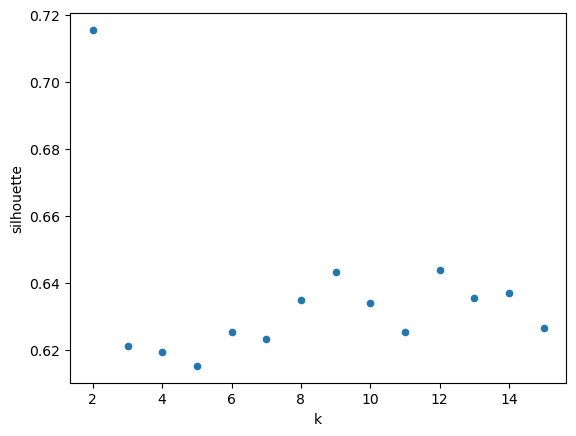

In [15]:
amtrak_result_df = test_values_of_k(range(2,16), amtrak_distance_array)

In [16]:
amtrak_medoids, amtrak_labels = write_kmedoid(amtrak_distance_array, 
                                              amtrak_index, 
                                              8, 
                                              "medoid", 
                                              "partitionId")

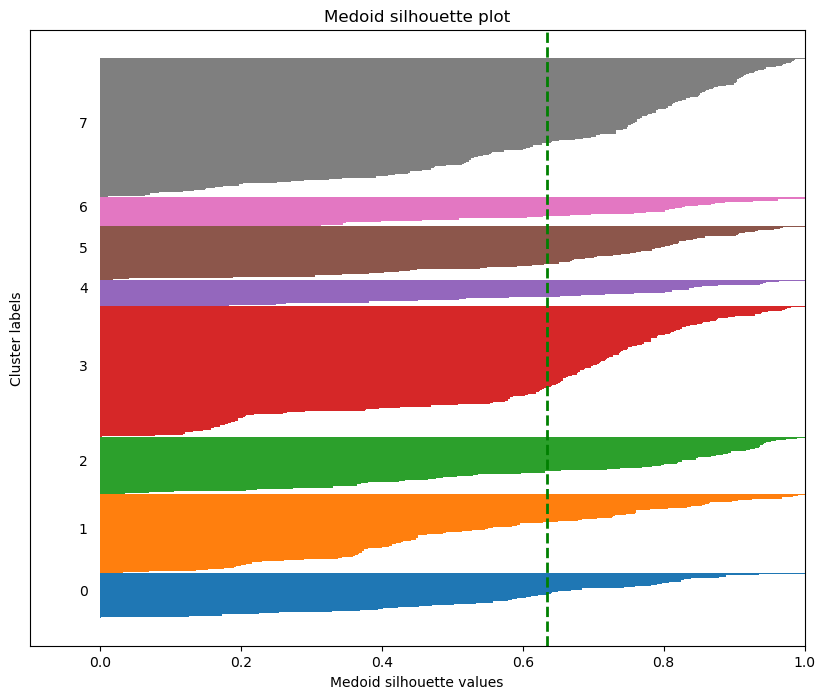

In [17]:
create_silhouette_plot(amtrak_distance_array, amtrak_labels, amtrak_medoids)